In [1]:
import os
import pandas as pd
import pickle
import shutil
import numpy as np
import seaborn as sns
from sklearn.datasets import load_files
from keras.utils import np_utils
import matplotlib.pyplot as plt
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, AveragePooling2D, Flatten, Dense, Dropout, Input
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.utils.vis_utils import plot_model
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
from keras.models import Model
from keras.layers.merge import concatenate

from PIL import ImageFile   
from sklearn.model_selection import train_test_split
from keras.preprocessing import image                  
from tqdm import tqdm

from keras.applications.inception_v3 import InceptionV3

# Defining the train,test and model directories

In [2]:
TEST_DIR = 'imgs/test'
TRAIN_DIR = 'imgs/train'
MODEL_PATH = 'model/GoogLeNet'
PICKLE_PATH = 'pickle'
CSV_DIR = 'csv_files'

In [3]:
if not os.path.exists(TEST_DIR):
    print("Testing data does not exists")
if not os.path.exists(TRAIN_DIR):
    print("Training data does not exists")
if not os.path.exists(MODEL_PATH):
    print("Model ResNet path does not exists")
    os.makedirs(MODEL_PATH)
    print("Model ResNet path created")
if not os.path.exists(PICKLE_PATH):
    os.makedirs(PICKLE_DIR)
if not os.path.exists(CSV_DIR):
    os.makedirs(CSV_DIR)# Data Preparation

# Data Preparation

In [4]:
data_train = pd.read_csv('csv_files/train.csv')
data_test = pd.read_csv('csv_files/test.csv')

### Converting into numerical values

In [5]:
labels_list = list(set(data_train['ClassName'].values.tolist()))
labels_id = {label_name:id for id,label_name in enumerate(labels_list)}
print(labels_id)
data_train['ClassName'].replace(labels_id,inplace=True)

{'c0': 0, 'c2': 1, 'c8': 2, 'c5': 3, 'c9': 4, 'c1': 5, 'c6': 6, 'c7': 7, 'c3': 8, 'c4': 9}


In [6]:
with open('pickle/labels_list.pkl', "wb") as handle:
    pickle.dump(labels_id,handle)

In [7]:
labels = to_categorical(data_train['ClassName'])
print(labels.shape)# Splitting into Train and Test sets

(22424, 10)


# Splitting into Train and Test sets

In [8]:
from sklearn.model_selection import train_test_split

xtrain,xtest,ytrain,ytest = train_test_split(data_train.iloc[:,0],labels,test_size = 0.2,random_state=42)

In [9]:
def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(128, 128))
    # convert PIL.Image.Image type to 3D tensor with shape (128, 128, 3)
    x = image.img_to_array(img)
   # convert 3D tensor to 4D tensor with shape (1, 128, 128, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [10]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(xtrain).astype('float32')/255 - 0.5
valid_tensors = paths_to_tensor(xtest).astype('float32')/255 - 0.5

100%|█████████████████████████████████████████████████████████████████████████████| 4485/4485 [00:16<00:00, 264.69it/s]


# InceptionV3

In [11]:
model = InceptionV3(include_top=False, input_shape=(128,128,3))
model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 63, 63, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 63, 63, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 63, 63, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [12]:
train_inception = model.predict(train_tensors,verbose=1)
valid_inception = model.predict(valid_tensors,verbose=1)

141/141 [==============================] - 5s 33ms/step


In [13]:
print("Train shape",train_inception.shape)
print("Validation shape",valid_inception.shape)

Train shape (17939, 2, 2, 2048)
Validation shape (4485, 2, 2, 2048)


In [14]:
train_features = train_inception[0]
valid_features = valid_inception[0]

In [15]:
print("Train features shape",train_features.shape)
print("Validation features shape",valid_features.shape)

Train features shape (2, 2, 2048)
Validation features shape (2, 2, 2048)


In [16]:
InceptionV3_model = Sequential()
InceptionV3_model.add(GlobalAveragePooling2D(input_shape=train_features.shape))
InceptionV3_model.add(Dense(10, activation='softmax', kernel_initializer='glorot_normal'))

InceptionV3_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                20490     
Total params: 20,490
Trainable params: 20,490
Non-trainable params: 0
_________________________________________________________________


In [17]:
InceptionV3_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [18]:
filepath = os.path.join(MODEL_PATH,"distracted-{epoch:02d}-{val_accuracy:.2f}.hdf5")
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max',period=1)
callbacks_list = [checkpoint]

In [19]:
model_history = InceptionV3_model.fit(train_inception,ytrain,validation_data = (valid_inception, ytest),epochs=400, batch_size=16, shuffle=True, callbacks=callbacks_list)

Epoch 1/400
1122/1122 [==============================] - 9s 3ms/step - loss: 1.8194 - accuracy: 0.4589 - val_loss: 0.7241 - val_accuracy: 0.7779

Epoch 00001: val_accuracy improved from -inf to 0.77793, saving model to model/GoogLeNet\distracted-01-0.78.hdf5
Epoch 2/400
1122/1122 [==============================] - 3s 3ms/step - loss: 0.6374 - accuracy: 0.7961 - val_loss: 0.8467 - val_accuracy: 0.7496

Epoch 00002: val_accuracy did not improve from 0.77793
Epoch 3/400
1122/1122 [==============================] - 3s 3ms/step - loss: 0.4707 - accuracy: 0.8509 - val_loss: 0.4972 - val_accuracy: 0.8466

Epoch 00003: val_accuracy improved from 0.77793 to 0.84660, saving model to model/GoogLeNet\distracted-03-0.85.hdf5
Epoch 4/400
1122/1122 [==============================] - 3s 3ms/step - loss: 0.3632 - accuracy: 0.8831 - val_loss: 0.4333 - val_accuracy: 0.8707

Epoch 00004: val_accuracy improved from 0.84660 to 0.87068, saving model to model/GoogLeNet\distracted-04-0.87.hdf5
Epoch 5/400
1122

1122/1122 [==============================] - 3s 3ms/step - loss: 0.0410 - accuracy: 0.9878 - val_loss: 0.5501 - val_accuracy: 0.8945

Epoch 00039: val_accuracy did not improve from 0.90591
Epoch 40/400
1122/1122 [==============================] - 3s 3ms/step - loss: 0.0355 - accuracy: 0.9874 - val_loss: 0.5693 - val_accuracy: 0.8919

Epoch 00040: val_accuracy did not improve from 0.90591
Epoch 41/400
1122/1122 [==============================] - 3s 3ms/step - loss: 0.0344 - accuracy: 0.9886 - val_loss: 0.6913 - val_accuracy: 0.8687

Epoch 00041: val_accuracy did not improve from 0.90591
Epoch 42/400
1122/1122 [==============================] - 3s 3ms/step - loss: 0.0344 - accuracy: 0.9883 - val_loss: 0.6058 - val_accuracy: 0.8883

Epoch 00042: val_accuracy did not improve from 0.90591
Epoch 43/400
1122/1122 [==============================] - 3s 3ms/step - loss: 0.0349 - accuracy: 0.9893 - val_loss: 0.5600 - val_accuracy: 0.8936

Epoch 00043: val_accuracy did not improve from 0.90591
Epo

1122/1122 [==============================] - 3s 3ms/step - loss: 0.0115 - accuracy: 0.9965 - val_loss: 0.8402 - val_accuracy: 0.8816

Epoch 00079: val_accuracy did not improve from 0.90591
Epoch 80/400
1122/1122 [==============================] - 3s 3ms/step - loss: 0.0115 - accuracy: 0.9969 - val_loss: 0.8212 - val_accuracy: 0.8881

Epoch 00080: val_accuracy did not improve from 0.90591
Epoch 81/400
1122/1122 [==============================] - 3s 3ms/step - loss: 0.0124 - accuracy: 0.9958 - val_loss: 0.8198 - val_accuracy: 0.8876

Epoch 00081: val_accuracy did not improve from 0.90591
Epoch 82/400
1122/1122 [==============================] - 3s 3ms/step - loss: 0.0107 - accuracy: 0.9967 - val_loss: 0.7956 - val_accuracy: 0.8936

Epoch 00082: val_accuracy did not improve from 0.90591
Epoch 83/400
1122/1122 [==============================] - 3s 3ms/step - loss: 0.0093 - accuracy: 0.9974 - val_loss: 0.8546 - val_accuracy: 0.8892

Epoch 00083: val_accuracy did not improve from 0.90591
Epo


Epoch 00119: val_accuracy did not improve from 0.90591
Epoch 120/400
1122/1122 [==============================] - 3s 3ms/step - loss: 0.0063 - accuracy: 0.9984 - val_loss: 1.0572 - val_accuracy: 0.8845

Epoch 00120: val_accuracy did not improve from 0.90591
Epoch 121/400
1122/1122 [==============================] - 3s 3ms/step - loss: 0.0055 - accuracy: 0.9981 - val_loss: 1.0812 - val_accuracy: 0.8800

Epoch 00121: val_accuracy did not improve from 0.90591
Epoch 122/400
1122/1122 [==============================] - 3s 3ms/step - loss: 0.0041 - accuracy: 0.9990 - val_loss: 1.1457 - val_accuracy: 0.8760

Epoch 00122: val_accuracy did not improve from 0.90591
Epoch 123/400
1122/1122 [==============================] - 3s 3ms/step - loss: 0.0048 - accuracy: 0.9985 - val_loss: 1.0946 - val_accuracy: 0.8798

Epoch 00123: val_accuracy did not improve from 0.90591
Epoch 124/400
1122/1122 [==============================] - 3s 3ms/step - loss: 0.0048 - accuracy: 0.9987 - val_loss: 1.0966 - val_ac

1122/1122 [==============================] - 3s 3ms/step - loss: 0.0023 - accuracy: 0.9993 - val_loss: 1.3339 - val_accuracy: 0.8765

Epoch 00160: val_accuracy did not improve from 0.90591
Epoch 161/400
1122/1122 [==============================] - 3s 3ms/step - loss: 0.0035 - accuracy: 0.9988 - val_loss: 1.3310 - val_accuracy: 0.8756

Epoch 00161: val_accuracy did not improve from 0.90591
Epoch 162/400
1122/1122 [==============================] - 3s 3ms/step - loss: 0.0024 - accuracy: 0.9994 - val_loss: 1.3320 - val_accuracy: 0.8769

Epoch 00162: val_accuracy did not improve from 0.90591
Epoch 163/400
1122/1122 [==============================] - 3s 3ms/step - loss: 0.0015 - accuracy: 0.9997 - val_loss: 1.3552 - val_accuracy: 0.8742

Epoch 00163: val_accuracy did not improve from 0.90591
Epoch 164/400
1122/1122 [==============================] - 3s 3ms/step - loss: 0.0032 - accuracy: 0.9991 - val_loss: 1.4105 - val_accuracy: 0.8745

Epoch 00164: val_accuracy did not improve from 0.90591

1122/1122 [==============================] - 3s 3ms/step - loss: 0.0012 - accuracy: 0.9996 - val_loss: 1.6837 - val_accuracy: 0.8700

Epoch 00200: val_accuracy did not improve from 0.90591
Epoch 201/400
1122/1122 [==============================] - 3s 3ms/step - loss: 9.8738e-04 - accuracy: 0.9998 - val_loss: 1.6119 - val_accuracy: 0.8747

Epoch 00201: val_accuracy did not improve from 0.90591
Epoch 202/400
1122/1122 [==============================] - 3s 3ms/step - loss: 0.0013 - accuracy: 0.9995 - val_loss: 1.6739 - val_accuracy: 0.8689

Epoch 00202: val_accuracy did not improve from 0.90591
Epoch 203/400
1122/1122 [==============================] - 3s 3ms/step - loss: 0.0013 - accuracy: 0.9998 - val_loss: 1.6946 - val_accuracy: 0.8673

Epoch 00203: val_accuracy did not improve from 0.90591
Epoch 204/400
1122/1122 [==============================] - 3s 3ms/step - loss: 0.0018 - accuracy: 0.9995 - val_loss: 1.6276 - val_accuracy: 0.8716

Epoch 00204: val_accuracy did not improve from 0.9

1122/1122 [==============================] - 3s 3ms/step - loss: 5.3981e-04 - accuracy: 0.9999 - val_loss: 1.8347 - val_accuracy: 0.8685

Epoch 00240: val_accuracy did not improve from 0.90591
Epoch 241/400
1122/1122 [==============================] - 3s 3ms/step - loss: 7.0950e-04 - accuracy: 0.9998 - val_loss: 1.8197 - val_accuracy: 0.8693

Epoch 00241: val_accuracy did not improve from 0.90591
Epoch 242/400
1122/1122 [==============================] - 3s 3ms/step - loss: 8.4310e-04 - accuracy: 0.9997 - val_loss: 1.8580 - val_accuracy: 0.8682

Epoch 00242: val_accuracy did not improve from 0.90591
Epoch 243/400
1122/1122 [==============================] - 3s 3ms/step - loss: 8.6279e-04 - accuracy: 0.9998 - val_loss: 1.8958 - val_accuracy: 0.8656

Epoch 00243: val_accuracy did not improve from 0.90591
Epoch 244/400
1122/1122 [==============================] - 3s 3ms/step - loss: 5.5457e-04 - accuracy: 0.9999 - val_loss: 1.8717 - val_accuracy: 0.8664

Epoch 00244: val_accuracy did not 


Epoch 00279: val_accuracy did not improve from 0.90591
Epoch 280/400
1122/1122 [==============================] - 3s 3ms/step - loss: 4.1458e-04 - accuracy: 0.9999 - val_loss: 2.1400 - val_accuracy: 0.8640

Epoch 00280: val_accuracy did not improve from 0.90591
Epoch 281/400
1122/1122 [==============================] - 3s 3ms/step - loss: 4.5984e-04 - accuracy: 1.0000 - val_loss: 2.1303 - val_accuracy: 0.8658

Epoch 00281: val_accuracy did not improve from 0.90591
Epoch 282/400
1122/1122 [==============================] - 3s 3ms/step - loss: 3.6358e-04 - accuracy: 1.0000 - val_loss: 2.1122 - val_accuracy: 0.8673

Epoch 00282: val_accuracy did not improve from 0.90591
Epoch 283/400
1122/1122 [==============================] - 3s 3ms/step - loss: 6.0158e-04 - accuracy: 0.9998 - val_loss: 2.1256 - val_accuracy: 0.8664

Epoch 00283: val_accuracy did not improve from 0.90591
Epoch 284/400
1122/1122 [==============================] - 3s 3ms/step - loss: 4.0367e-04 - accuracy: 0.9999 - val_l

1122/1122 [==============================] - 3s 3ms/step - loss: 4.3157e-04 - accuracy: 0.9999 - val_loss: 2.3776 - val_accuracy: 0.8653

Epoch 00319: val_accuracy did not improve from 0.90591
Epoch 320/400
1122/1122 [==============================] - 3s 3ms/step - loss: 2.5966e-04 - accuracy: 0.9999 - val_loss: 2.3819 - val_accuracy: 0.8629

Epoch 00320: val_accuracy did not improve from 0.90591
Epoch 321/400
1122/1122 [==============================] - 3s 3ms/step - loss: 3.2640e-04 - accuracy: 0.9998 - val_loss: 2.3922 - val_accuracy: 0.8613

Epoch 00321: val_accuracy did not improve from 0.90591
Epoch 322/400
1122/1122 [==============================] - 3s 3ms/step - loss: 2.9917e-04 - accuracy: 0.9999 - val_loss: 2.3957 - val_accuracy: 0.8622

Epoch 00322: val_accuracy did not improve from 0.90591
Epoch 323/400
1122/1122 [==============================] - 3s 3ms/step - loss: 2.1157e-04 - accuracy: 1.0000 - val_loss: 2.4019 - val_accuracy: 0.8638

Epoch 00323: val_accuracy did not 


Epoch 00358: val_accuracy did not improve from 0.90591
Epoch 359/400
1122/1122 [==============================] - 3s 3ms/step - loss: 2.4511e-04 - accuracy: 1.0000 - val_loss: 2.6545 - val_accuracy: 0.8589

Epoch 00359: val_accuracy did not improve from 0.90591
Epoch 360/400
1122/1122 [==============================] - 3s 3ms/step - loss: 2.2625e-04 - accuracy: 0.9999 - val_loss: 2.6577 - val_accuracy: 0.8602

Epoch 00360: val_accuracy did not improve from 0.90591
Epoch 361/400
1122/1122 [==============================] - 3s 3ms/step - loss: 1.0611e-04 - accuracy: 1.0000 - val_loss: 2.7064 - val_accuracy: 0.8595

Epoch 00361: val_accuracy did not improve from 0.90591
Epoch 362/400
1122/1122 [==============================] - 3s 3ms/step - loss: 1.8995e-04 - accuracy: 1.0000 - val_loss: 2.6792 - val_accuracy: 0.8591

Epoch 00362: val_accuracy did not improve from 0.90591
Epoch 363/400
1122/1122 [==============================] - 3s 3ms/step - loss: 1.8826e-04 - accuracy: 1.0000 - val_l

1122/1122 [==============================] - 3s 3ms/step - loss: 3.5869e-04 - accuracy: 0.9999 - val_loss: 2.8969 - val_accuracy: 0.8604

Epoch 00398: val_accuracy did not improve from 0.90591
Epoch 399/400
1122/1122 [==============================] - 3s 3ms/step - loss: 2.4874e-04 - accuracy: 0.9998 - val_loss: 2.9267 - val_accuracy: 0.8571

Epoch 00399: val_accuracy did not improve from 0.90591
Epoch 400/400
1122/1122 [==============================] - 3s 3ms/step - loss: 1.0302e-04 - accuracy: 1.0000 - val_loss: 2.8886 - val_accuracy: 0.8602

Epoch 00400: val_accuracy did not improve from 0.90591


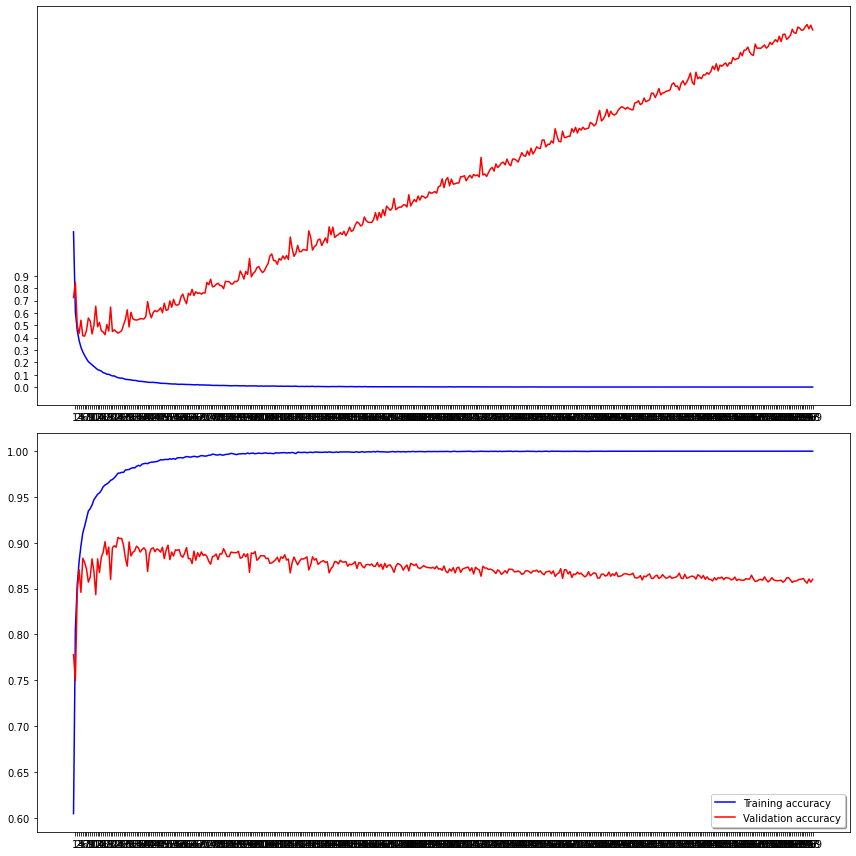

In [20]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(model_history.history['loss'], color='b', label="Training loss")
ax1.plot(model_history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, 400, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(model_history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(model_history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, 400, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [21]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    fig.savefig(os.path.join(MODEL_PATH,"confusion_matrix.png"))
    return fig

In [22]:
def print_heatmap(n_labels, n_predictions, class_names):
    labels = n_labels #sess.run(tf.argmax(n_labels, 1))
    predictions = n_predictions #sess.run(tf.argmax(n_predictions, 1))

#     confusion_matrix = sess.run(tf.contrib.metrics.confusion_matrix(labels, predictions))
    matrix = confusion_matrix(labels.argmax(axis=1),predictions.argmax(axis=1))
    row_sum = np.sum(matrix, axis = 1)
    w, h = matrix.shape

    c_m = np.zeros((w, h))

    for i in range(h):
        c_m[i] = matrix[i] * 100 / row_sum[i]

    c = c_m.astype(dtype = np.uint8)

    
    heatmap = print_confusion_matrix(c, class_names, figsize=(18,10), fontsize=20)

In [25]:
class_names = list()
for name,idx in labels_id.items():
    class_names.append(name)
# print(class_names)
ypred = InceptionV3_model.predict(valid_inception,verbose=1)

141/141 [==============================] - 0s 1ms/step


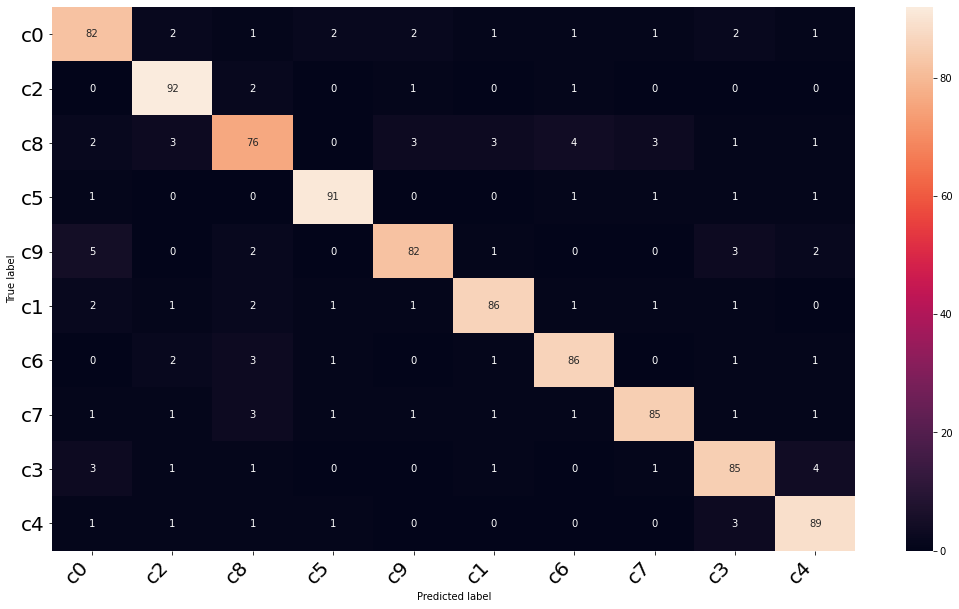

In [26]:
print_heatmap(ytest,ypred,class_names)

In [27]:
ypred_class = np.argmax(ypred,axis=1)
# print(ypred_class[:10])
ytest = np.argmax(ytest,axis=1)

In [28]:
accuracy = accuracy_score(ytest,ypred_class)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(ytest, ypred_class,average='weighted')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(ytest,ypred_class,average='weighted')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(ytest,ypred_class,average='weighted')
print('F1 score: %f' % f1)

Accuracy: 0.860201
Precision: 0.860223
Recall: 0.860201
F1 score: 0.860021
